In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("precision", 2)
pd.options.display.float_format = '{:20,.2f}'.format

%matplotlib inline

# NYC Restaurants dataset

Source: https://data.cityofnewyork.us/Health/Restaurant-Grades/gra9-xbjk/data

In [3]:
df = pd.read_csv("Restaurant_Grades.csv")

In [4]:
# Describe the data
df.head(5)

,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE
0,DARKHORSE,MANHATTAN,17,MURRAY STREET,10007,American,Pesticide use not in accordance with label or ...,Not Critical,13.00,A,5/20/2016,3/18/2018
1,LOTS O BAGELS,QUEENS,3005,BROADWAY,11106,Bagels/Pretzels,Filth flies or food/refuse/sewage-associated (...,Critical,9.00,A,4/2/2015,3/18/2018
2,LOTUS CAFE & BAGELS,BROOKLYN,4,NEPTUNE AVENUE,11235,American,Facility not vermin proof. Harborage or condit...,Not Critical,12.00,A,1/25/2017,3/18/2018
3,SUBWAY,BRONX,1490,BOSTON ROAD,10460,Sandwiches,Food Protection Certificate not held by superv...,Critical,12.00,A,12/27/2017,3/18/2018
4,810 DELI & CAFE,MANHATTAN,810,7 AVENUE,10019,American,Plumbing not properly installed or maintained;...,Not Critical,9.00,A,11/15/2017,3/18/2018


In [5]:
# Replace spaces with underscores
df.columns = df.columns.str.replace(" ","_")

# Convert dates to datetime
df.GRADE_DATE = pd.to_datetime(df.GRADE_DATE, format="%m/%d/%Y")
df.RECORD_DATE = pd.to_datetime(df.RECORD_DATE, format="%m/%d/%Y")

# Create a unique key based on restaurant
df["KEY"] = df[['DBA', 'BUILDING', "STREET", "ZIPCODE"]].astype(str).apply(lambda x: ' '.join(x), axis=1)
print("num ratings: {} num unique restaurants: {}".format(len(df), len(df.KEY.unique())))
df[["KEY"]].head(5)

num ratings: 186185 num unique restaurants: 24614


,KEY
0,DARKHORSE 17 MURRAY STREET 10007
1,LOTS O BAGELS 3005 BROADWAY 11106
2,LOTUS CAFE & BAGELS 4 NEPTUNE AVENUE 11235
3,SUBWAY 1490 BOSTON ROAD 10460
4,810 DELI & CAFE 810 7 AVENUE 10019


In [6]:
# Scores are broken down by critical, not critical and not applicable, which results in duplicate rows for the same rating
df = df[["KEY","DBA","CUISINE_DESCRIPTION","SCORE","GRADE","GRADE_DATE"]].drop_duplicates()
df = df.sort_values("GRADE_DATE")

## What is the breakdown of the ratings?

The score is from 0 up. Low score is good as it indicates no violations. Each violation has some point value so a score of 0 means there are no violations. There are three types of violations:

1.	General – e.g. not properly santizing cooking utensiles – min 2 points
2.	Critical – e.g. serving raw food such as a salad without properly washing it first – min 5 points
3.	Public Health Hazard – e.g. failing to keep food at right temperature – min 7 points

The final grade is based on the sum of all the points. A score of 0 to 13 earns an A. 14 to 27 earns a B and 28 or more earns a C. Below is a breakdown of the ratings


In [7]:
gb = df.groupby("GRADE").GRADE.agg(["count"])
gb["perc"] = gb / gb.sum()
gb

,count,perc
GRADE,,
A,70857,0.87
B,6721,0.08
C,1466,0.02
Not Yet Graded,2,0.00
P,1193,0.01
Z,972,0.01


I’m not surprised that the majority of grades are As with less that 2% of inspections resulting in a C grade. How about the distribution of the points?

In [8]:
# Define colors to be used in visualizations
colors = {"A": "darkseagreen", "B": "dodgerblue", "C": "lightcoral", "P": "wheat", "Z": "lightgrey", "Not Yet Graded": "lightgrey"}

Text(38,12000,'C')

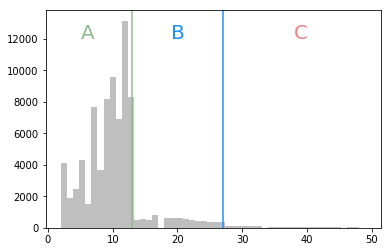

In [9]:
# Bar graph based on scores, segmented by grade

f, ax = plt.subplots()
ax.hist(df[(df.SCORE > 0) & (df.SCORE < 50)].SCORE,bins=50, color="grey",alpha=0.5)
plt.axvline(13,color=colors["A"],linestyle="-")
plt.text(5, 12000,"A",color=colors["A"], fontsize=20)
plt.axvline(27,color=colors["B"],linestyle="-")
plt.text(19, 12000,"B",color=colors["B"], fontsize=20)
plt.text(38, 12000,"C",color=colors["C"], fontsize=20)

There seems to be a steep drop-off on 14 points. My guess is that inspectors show leniency when nearing the cut-off threshold. If it’s close, they give the owner the benefit of receiving the higher grade since the letter grade is the most visible component to the customer. Another, less plausible explanation, is that restaurants understand there is some leniency with certain violations, so they allow themselves some violations while maintaining an A grade. Also, note that the cut-off exists from B to C grade as well, although it’s a steady decline leading up to the C score.

## Has there been grade inflation?

Text(0.5,1,'Ratings over time')

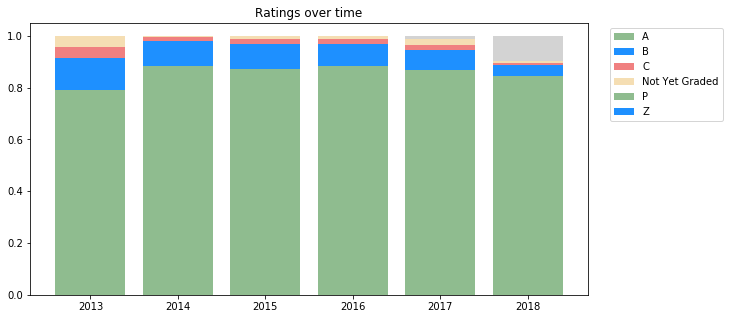

In [10]:
f, ax = plt.subplots(figsize=(10,5))

df["YEAR"] = df.GRADE_DATE.dt.year

gb = df[["YEAR", "GRADE","SCORE"]].groupby(["YEAR","GRADE"]).agg("count")
gb["perc"] = gb / gb.sum(level=0)

for year in df.YEAR.unique():
    bottom = 0
    for grade in sorted(df.GRADE.unique()):
        perc = gb[(gb.index.get_level_values(0) == year) & (gb.index.get_level_values(1) == grade)].perc
        if len(perc) > 0:
            perc = perc.values[0]
            ax.bar(year, perc, bottom=bottom, color=colors[grade])
            bottom += perc

ax.legend(sorted(df.GRADE.unique()), bbox_to_anchor=(1.25,1), loc="upper right")
ax.set_title("Ratings over time")

No

## What restaurants have the best rating for their cuisine?

In [12]:
gb = df.groupby(["CUISINE_DESCRIPTION","DBA"]).GRADE.agg(["count"])
gb = gb[gb["count"] > 50]
popular = gb.index.get_level_values(1).unique()
df_popular = df[df.DBA.isin(popular)].copy()

for pop in popular:
    # Replace cuisine description of each restaurant with most common
    new_cuisine_description = df_popular[df_popular.DBA == pop].CUISINE_DESCRIPTION.mode()[0]
    df_popular.loc[df_popular.DBA == pop, "CUISINE_DESCRIPTION"] = new_cuisine_description

df_popular["MEDIAN"] = df_popular.groupby(["CUISINE_DESCRIPTION","DBA"],sort=False).SCORE.transform(np.median)
df_popular["MEAN"] = df_popular.groupby(["CUISINE_DESCRIPTION","DBA"],sort=False).SCORE.transform(np.mean)
df_popular["MIN"] = df_popular.groupby(["CUISINE_DESCRIPTION","DBA"],sort=False).SCORE.transform(np.min)
df_popular["MAX"] = df_popular.groupby(["CUISINE_DESCRIPTION","DBA"],sort=False).SCORE.transform(np.max)
df_popular["STD"] = df_popular.groupby(["CUISINE_DESCRIPTION","DBA"],sort=False).SCORE.transform(np.std)

df_popular.sort_values(["CUISINE_DESCRIPTION", "MEDIAN"], ascending=[True,True]).groupby(["CUISINE_DESCRIPTION","DBA","MEDIAN","MEAN","MIN","MAX","STD"],sort=False).SCORE.agg("count")

CUISINE_DESCRIPTION              DBA                                    MEDIAN  MEAN   MIN   MAX    STD 
American                         APPLEBEE'S                              8.00    7.76  2.00  13.00  3.53      92
                                 AMC THEATRES                            9.50    9.11  2.00  45.00  6.76      56
                                 CHECKERS                               10.00    9.14  0.00  26.00  4.31     111
                                 BOSTON MARKET                          10.00    9.54  3.00  20.00  3.19      71
CafÃ©/Coffee/Tea                 STARBUCKS                               5.00    6.30  0.00  27.00  3.69     947
                                 STARBUCKS COFFEE                        5.00    6.54  2.00  17.00  3.64      79
Caribbean                        GOLDEN KRUST CARIBBEAN BAKERY & GRILL  10.00   10.51  2.00  46.00  5.55     182
Chicken                          POPEYES LOUISIANA KITCHEN               9.00    8.60  2.00  32.00  4.60

The ratings are surprisingly good, but I suppose that’s expected for large chains. Some establishments like Applebee’s and White Castle (!) have never received a grade other than A. Other groups like  Domino’s are very inconsistent (standard deviation of 9.43) but almost always bad (median score 13.63). But almost all large establishments have a few blemishes with max scores amounting to a C grade.

## Probability of transitioning from one state to the other (roll rates)

In [ ]:
max_num_ratings = max(df.groupby("KEY").size())
columns = [idx for idx in range(max_num_ratings)]
columns.insert(0, "KEY")
df_rest = pd.DataFrame(columns=columns)

for key in df.KEY.unique():
    df_key = df[df.KEY == key]
    new_row = {col: "NA" for col in columns}
    new_row = {"KEY": key}
    for idx, (k, v) in enumerate(df_key.iterrows()):
        new_row[idx] = v.GRADE
    
    df_rest = pd.concat([df_rest, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    
df_rolls = pd.DataFrame(columns=[1,2])
for c1 in range(max_num_ratings - 2):
    c2 = c1 +  1
    df_rest_valid = df_rest[(~df_rest[c1].isna()) & (~df_rest[c2].isna())]
    df_roll = pd.concat([df_rest_valid[c1], df_rest_valid[c2]], axis=1)
    df_roll.columns = [1,2]
    df_rolls = pd.concat([df_rolls, df_roll], ignore_index=True)
    
df_rolls.head()

In [ ]:
states = ["A","B","C","P","Z"]
df_roll_rates = pd.DataFrame(np.zeros([5,5]), columns=states, index=states)
for s1 in states:
    for s2 in states:
        num_match = sum((df_rolls[1] == s1) & (df_rolls[2] == s2))
        num_all = sum(df_rolls[1] == s1)
        if num_all > 0:
            df_roll_rates.loc[s2,s1] = num_match / num_all

df_roll_rates.columns.name = "from"
df_roll_rates.index.name = "to"

df_roll_rates * 100
